In [26]:
import numpy as np
import matplotlib.pylab as plt

import sys
sys.path.append('../')

from tidy3d import *
import tidy3d_core as tdcore

# make samplers that define the freq and time domain measurement
frequency_sampler = uniform_freq_sampler(f_start=5, f_stop=10, N_freqs=101)
time_sampler = uniform_time_sampler(t_start=0, t_stop=100, t_step=1)

num_modes = 10

SIM = Simulation(
    size=(5.0, 5.0, 5.0),
    grid_size=(0.1, 0.1, 0.1),
    monitors={
        "field_freq": FieldMonitor(
            size=(5,5,5),
            center=(0,0,0),
            sampler=frequency_sampler),
        "flux_freq": FluxMonitor(
            size=(1,1,0),
            center=(0,0,0),
            sampler=frequency_sampler),
        "flux_time": FluxMonitor(
            size=(1,1,0),
            center=(0,0,0),
            sampler=time_sampler),
        "mode": ModeMonitor(
            size=(1,1,0),
            center=(0,0,0),
            sampler=frequency_sampler,
            modes=[Mode(mode_index=i) for i in range(num_modes)])
    },
)


## Run Simulation & Load Results

This is technically what would be done through webAPI.

For simplicity calling `tidy3d_core` (backend) directly to do it here with some generated data.

### Solving Simulation

`tdcore.solve()` takes `Simulation` and returns dictionary of `{monitor_name (str): monitor_data_dict (dict)}`

`monitor_data_dict` is just a dictionary of `{data_name (str): data_value (np.ndarray)}`

where `data_name=data`is reserved for the raw data and the other keys are coordinates (`xs`, `ys`, `zs`, `mode_index`, `freqs`, etc)

In [27]:
solver_data_dict = tdcore.solve(SIM)

### Loading Results into Simulation and Monitor data
`tdcore.load_solver_results()` takes the solver_data_dict and the original simulation and returns an instance of `td.SimulationData`
    
`td.SimulationData.monitor_data` is a dictionary of `{monitor_name (str): monitor_data (td.MonitorData)}`
    
`td.MonitorData` has a subclass for each `td.Monitor` type.

Each inherit from `xarray.DataArray`, so have the same methods.  See [here](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.html) for a comprehensive list.

In [28]:
data = tdcore.load_solver_results(simulation=SIM, solver_data_dict=solver_data_dict)

## Plotting

Here we show how to plot data from each monitor

### Plotting Flux Data

Flux data is the simplest because it just stores the flux values as a function of the sampler values, In this case, frequency.

/usr/local/lib/python3.9/site-packages/numpy/lib/histograms.py:851: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/usr/local/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/var/folders/jx/9y0mtn3s3zzb6mzgmsw6s6gr0000gn/T/ipykernel_96834/4103822980.py:7: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


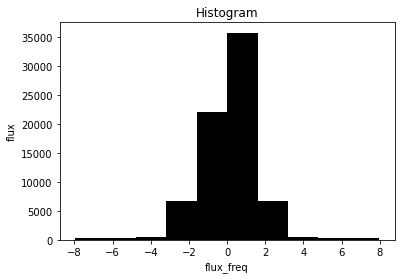

In [29]:
# get the flux data from that monitor name
flux_data = data.monitor_data['flux_freq']

# plot
flux_data.plot(color='k')
plt.ylabel('flux')
plt.show()

:DynamicMap   [field,component,zs,freqs]
   :Image   [xs,ys]   (flux_freq)

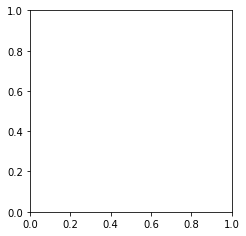

In [30]:
flux_data.visualize()

We can do the same for our time-domain flux monitor

/usr/local/lib/python3.9/site-packages/numpy/lib/histograms.py:851: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/usr/local/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/var/folders/jx/9y0mtn3s3zzb6mzgmsw6s6gr0000gn/T/ipykernel_96834/749432750.py:7: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


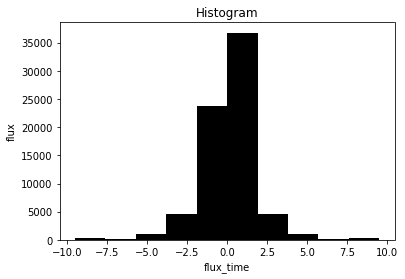

In [31]:
# get the flux data from that monitor name
flux_data = data.monitor_data['flux_time']

# plot
flux_data.plot(color='k')
plt.ylabel('flux')
plt.show()

In [32]:
d = flux_data.visualize()

## Plotting Mode Data

The axes of mode data correspond to direction (+/-), mode_index, and sampler axes. 

To pot all of this data, we make two subplots and use the builting `.sel()` function to select the data to plot in each axis.

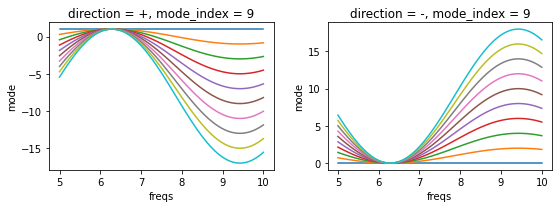

In [33]:
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(8, 3))

# get the mode data from that monitor name
mode_data = data.monitor_data['mode']

# loop through direction / axis and mode index
for ax, pm in zip((ax1, ax2), ('+', '-')):
    for i in range(num_modes):

        # get the data for this direction and mode index as a function of frequency
        data_mode_i = mode_data.sel(direction=pm, mode_index=i)

        # plot the real part on the corresponding axis
        data_mode_i.real.plot(ax=ax)

:DynamicMap   [direction,mode_index]
   :Curve   [freqs]   (mode)
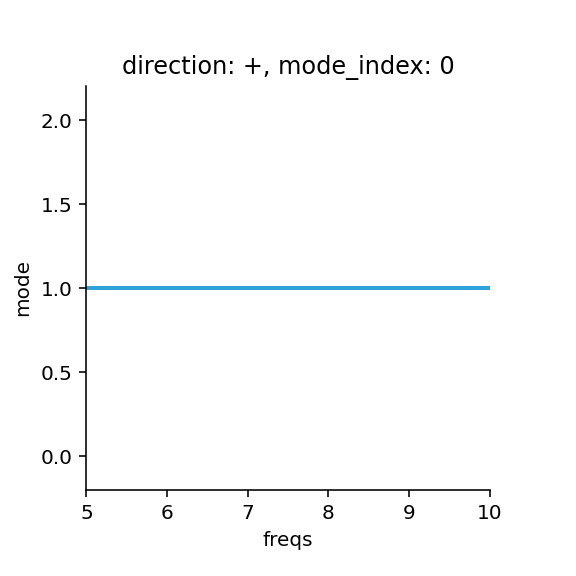

In [34]:
mode_data.real.visualize()

### Plotting Fields
Field data is more complicated to plot since it has so many dimensions.

If we reduce the data down to two dimensions, it will plot normally using `.plot()`, which calls `plt.pcolormesh`.


/var/folders/jx/9y0mtn3s3zzb6mzgmsw6s6gr0000gn/T/ipykernel_96834/3903799567.py:5: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


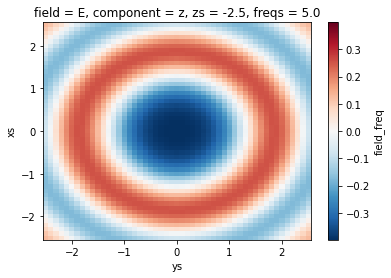

In [35]:
# get the field data
field_data = data.monitor_data['field_freq']

field_data.sel(field='E', component='z').isel(zs=0, freqs=0).real.plot()
plt.show()

For interactive plotting of the entire field data, the `holoviews` package can be used.
This will be integrated into the `td.FieldData` object natively in the future.

:DynamicMap   [field,component,zs,freqs]
   :Image   [xs,ys]   (field_freq)
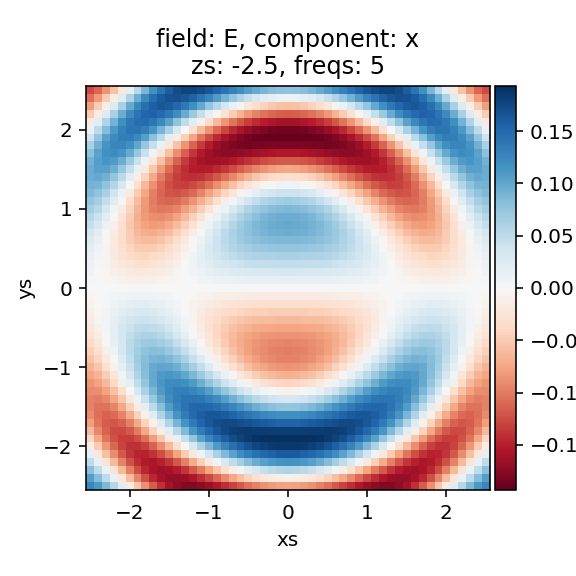

In [36]:
field_data.real.visualize()